In [186]:
%pwd
%cd template

[Errno 2] No such file or directory: 'template'
/mnt/d/src/learn-ml/template


In [187]:
%pwd

'/mnt/d/src/learn-ml/template'

In [196]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import set_config
from sklearn.cluster import KMeans

# Constants
data_file_path = "./data/home-data-for-ml-course/train.csv"
test_size = 0.2
val_size = 0.2
random_state = 0
set_config(transform_output="pandas")

# Load data
df = pd.read_csv(data_file_path)

# Target and features
target = "SalePrice"
y = df.SalePrice

# All numeric without missing values
features = list(set(df.columns) - set(["SalePrice"]))
X = df[features]

In [189]:
# Drop columns with missing values
cols_with_missing_vals = X.isnull().sum()
cols_with_missing_vals = set(cols_with_missing_vals[cols_with_missing_vals > 0].index)
X = X.drop(cols_with_missing_vals, axis = 1)

In [197]:
# Create some features
# LotFrontage: Linear feet of street connected to property
# LotArea: Lot size in square feet
# MasVnrArea: Masonry veneer area in square feet
# BsmtFinSF1: Type 1 finished square feet
# BsmtFinSF2: Type 2 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet
# BsmtFullBath: Basement full bathrooms
# BsmtHalfBath: Basement half bathrooms
# FullBath: Full bathrooms above grade
# HalfBath: Half baths above grade
# Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
# Kitchen: Kitchens above grade
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
# Fireplaces: Number of fireplaces
# GarageCars: Size of garage in car capacity
# GarageArea: Size of garage in square feet
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# PoolArea: Pool area in square feet
# MiscVal: $Value of miscellaneous feature
cols = ["LotArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","TotRmsAbvGrd","Fireplaces","GarageCars","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"]
N = len(cols)
for m in range(N):
    for n in range(m + 1, N):
        X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)

# The above transform divides one feature by another. Other possible transforms:
# logs, counts, splitting or combining string features, a grouped feature that
# the sample belongs to

/tmp/ipykernel_14656/243190038.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)
/tmp/ipykernel_14656/243190038.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)
/tmp/ipykernel_14656/243190038.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

In [211]:
# Use k-means to create cluster labels and use these as a feature
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto", max_iter=300).fit(X[["GrLivArea","TotalBsmtSF"]])
kmeans.labels_
X["cluster"] = kmeans.labels_

In [192]:
# Ordinal-encode categorical variables
pd.options.mode.chained_assignment = None

categorical_cols = list(X.select_dtypes(include=["object"]).columns)
discrete_features = (X.dtypes == "object").values
for col in categorical_cols:
    values, index = pd.factorize(X.loc[:, col])
    # Disable chained assignment for this line
    X[col] = values

pd.options.mode.chained_assignment = "warn"

In [193]:
from sklearn.feature_selection import mutual_info_regression

# Compute mutual information scores
mi_scores = pd.Series(
    data=mutual_info_regression(X, y, discrete_features=discrete_features),
        index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

OverallQual                 0.563076
Neighborhood                0.527192
GrLivArea                   0.485582
YearBuilt                   0.372379
GarageCars                  0.370907
                              ...   
BsmtFinSF1/EnclosedPorch    0.000000
BsmtFinSF1/3SsnPorch        0.000000
LowQualFinSF/PoolArea       0.000000
LowQualFinSF/3SsnPorch      0.000000
PoolArea/MiscVal            0.000000
Length: 337, dtype: float64

<Axes: ylabel='None'>

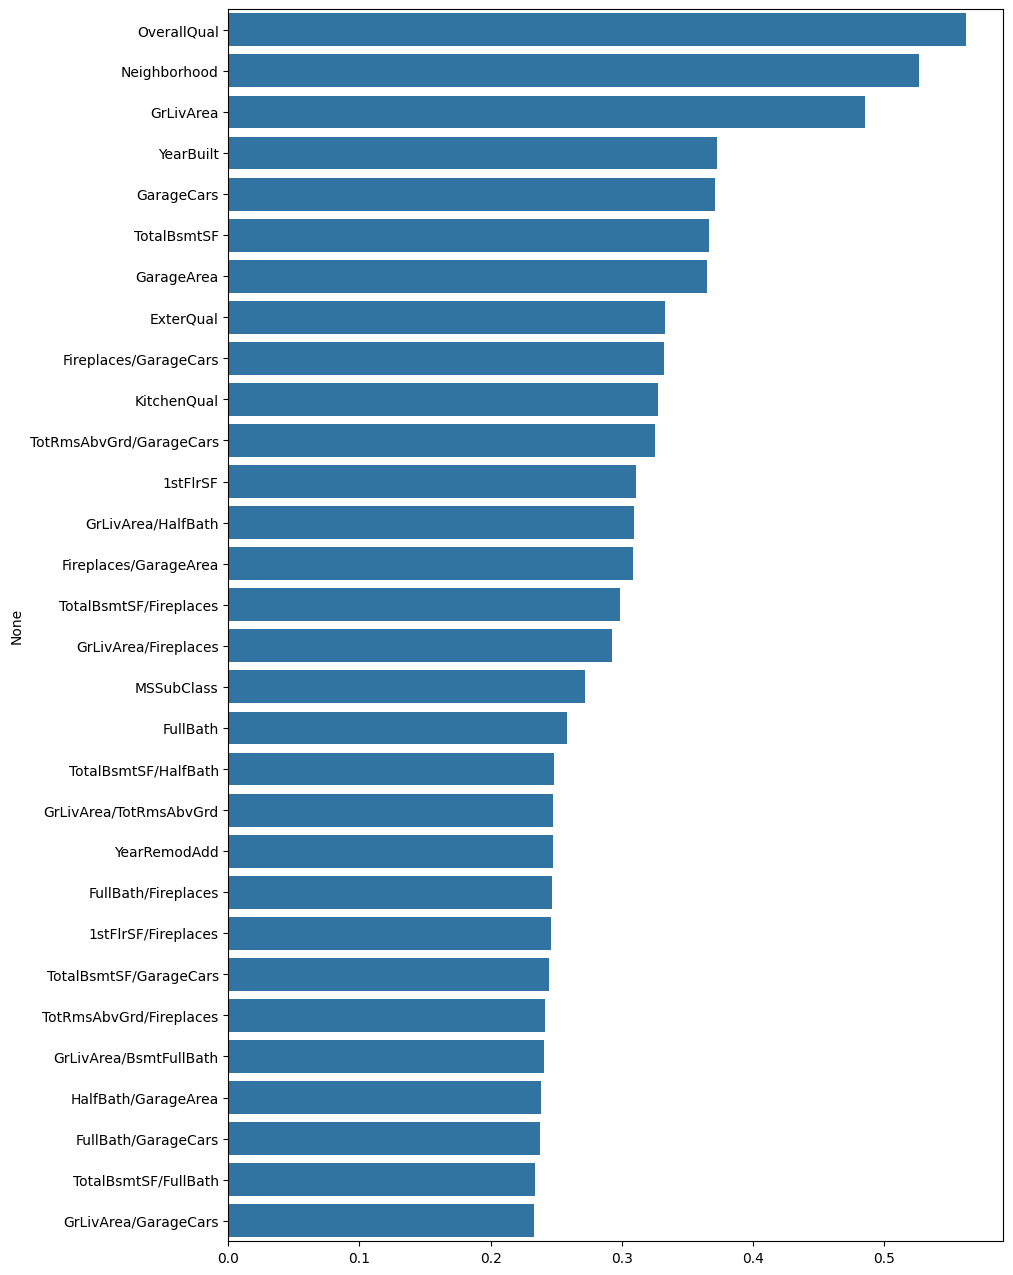

In [194]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10,16))
N = 30
sns.barplot(x=mi_scores.values[0:N], y=mi_scores.index[0:N])